# Inference on the generalized Galton board

This notebook uses the augmented data mined from the simulators to demonstrate the new simulation-based inference methods. The table below summarizes which methods utilize the joint score and joint ratio via the loss functions `L_t` and `L_r` .

<img  src="figures/table.png"  width="50%" align="center" />


<!--
<div>
<img  src="figures/mining_ppl.png"  width="200" align="left" />
<img  src="figures/joint_ratio_eqtn.png"  width="200" align="left" />
<img  src="figures/joint_score_eqtn.png"  width="200" align="right" />
</div>
-->

In [1]:
import numpy as np
from itertools import product
import import_ipynb

%matplotlib inline
import matplotlib.pyplot as plt

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, dot, concatenate
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.utils import to_categorical

Using TensorFlow backend.


In [27]:
from galton import galton_rvs, galton_rvs_ratio, check_random_state
from galton import n_nails, n_rows
from utils import calculate_height, adjust_margins

theta_0 = -0.8
theta_1 = -0.6

n_features = 1 
hidden_size = 10
n_outputs = n_nails
batch_size = 32
n_epochs = 50

## "True densities" from histograms

The probability mass function `p(x|θ)` implicitly defined by this simulator is intractable. To estimate the true density we run the simulator many times and make histograms for the outcomes. These are estimates of the implicit distributions, but inefficient for inference in more complex real-world problems.

In [3]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

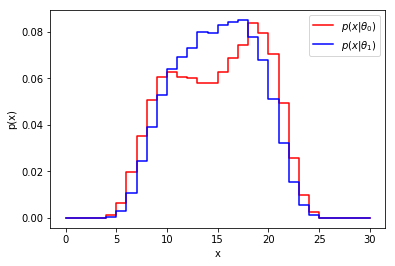

In [4]:
plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

## NDE and SCANDAL

First, we estimate the densities `p(x|θ)` (which are actually probability mass functions, since `x` is discrete) through a simple neural density estimator (NDE). We then compare this to the new SCANDAL (Score and neural density approximate likelihood) method. This technique uses the "gold" mined from the simulator, the joint score `t(x,z|θ)`, to guide the training of the neural density estimator. More precisely, the SCANDAL loss consists not just of the log likelihood, but adds the mean squared error between the derived score and the joint score available from the simulator.

In [28]:
def draw(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas
    
    all_x = []
    all_t_xz = []
    all_thetas = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(theta, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_t_xz[choices], all_thetas[choices]

In [29]:
def make_nde(lr=0.001):   
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)
    
    return model

In [30]:
def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1) 
    t_x = Lambda(lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], 
                 output_shape=(n_features,))([phat_x_theta, theta])
    
    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)
    
    return model

In [31]:
x, t_xz, theta = draw(1000)

In [32]:
nde = make_nde()
nde.fit(
    theta, x,
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

In [33]:
scandal = make_scandal()
scandal.fit(
    [theta, x],
    [x, t_xz],
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

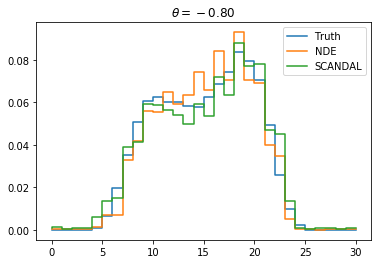

In [34]:
plt.step(range(n_nails), p_estimated_0, label="Truth")
plt.step(range(n_nails), nde.predict(np.array([theta_0])).ravel(), label="NDE")
plt.step(range(n_nails), scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0], label="SCANDAL")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

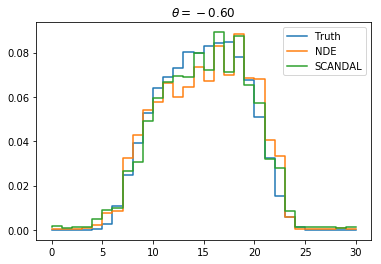

In [35]:
plt.step(range(n_nails), p_estimated_1, label="Truth")
plt.step(range(n_nails), nde.predict(np.array([theta_1])).ravel(), label="NDE")
plt.step(range(n_nails), scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0], label="SCANDAL")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

## Likelihood ratio trick (LRT)

A discriminative classifier trained to distinguish between equal-sized samples `x~p(x|θ0)` and `x~p(x|θ1)` can be used to define an estimator for the likelihood ratio `r(x|θ0,θ1) = p(x|θ0) / p(x|θ1)`. The reason behind this "likelihood ratio trick" is that the binary cross-entropy between these two samples is minimized by the optimal decision function `s*(x|θ0,θ1) = p(x|θ1) / (p(x|θ0) + p(x|θ1))`, or `r(x|θ0,θ1) = (1 - s*(x|θ0,θ1)) / s*(x|θ0,θ1)`.

In [36]:
def draw_lrt(n_samples, n_thetas=10, random_state=0):
    grid = list(product(np.linspace(-1.0, -0.4, n_thetas), 
                        np.linspace(-1.0, -0.4, n_thetas)))
    n_traces_per_theta = n_samples // (2 * len(grid))
    
    all_x = []
    all_theta = []
    all_y = []
    k = 0
    
    for theta_0, theta_1 in grid:
        x_0, _, _, _ = galton_rvs(theta_0, n_runs=n_traces_per_theta, random_state=random_state+k)
        x_1, _, _, _ = galton_rvs(theta_1, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x += x_0
        all_x += x_1
        all_theta += [[theta_0, theta_1]] * (n_traces_per_theta * 2)
        all_y += [0] * len(x_0)
        all_y += [1] * len(x_1)
        k += 1
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_theta = np.array(all_theta)
    all_x = np.hstack([all_x, all_theta])
    all_y = np.array(all_y)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_y[choices]

In [37]:
def make_lrt(lr=0.001):
    inputs = Input(shape=(2 + n_outputs, )) 
    thetas = Lambda(lambda x: x[:,-2:], output_shape=(2,))(inputs)
    x = Lambda(lambda x: x[:,:-2], output_shape=(n_outputs,))(inputs)
    
    h = Dense(hidden_size, activation="tanh")(inputs)
    shat_thetas = Dense(n_outputs, activation="sigmoid")(h)
    shat_x_thetas = dot([x, shat_thetas], axes=1)
    
    model = Model(inputs=[inputs], outputs=[shat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=["binary_crossentropy"], optimizer=opt)
    
    return model

In [38]:
def log_r_from_s(s, epsilon=1.e-6):
    return np.log((1. - s + epsilon) / (s + epsilon))

In [39]:
x, y = draw_lrt(1000)

In [40]:
lrt = make_lrt()

lrt.fit(
    x, y, 
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

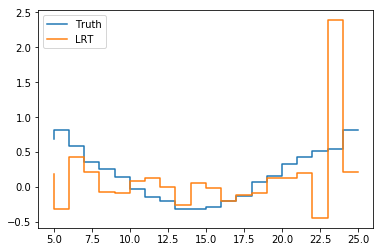

In [41]:
r_true = np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5])

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_lrt = log_r_from_s(lrt.predict(np.hstack([x_test,
                                 theta_0 * np.ones((n_nails, 1)), 
                                 theta_1 * np.ones((n_nails, 1))]))[5:-5])

plt.step(range(5, n_nails-5), r_true, label="Truth")
plt.step(range(5, n_nails-5), r_lrt, label="LRT")

plt.legend()
plt.show()

## ROLR and RASCAL

The "gold" that can be mined from the simulator consists not only of the score information used in SCANDAL, but also the joint likelihood ratios `r(x,z|θ0,θ1) = p(x,z|θ0) / p(x,z|θ1)`. The squared error loss functional between a function `r̂(x)` and the joint likelihood ratio available from the simulator sampled according to `θ1` is minimized by the intractable likelihood ratio `r̂(x) = r(x|θ0,θ1) = p(x|θ0) / p(x|θ1)`! Conversely, the squared error on `1/r(x|θ0,θ1)`, sampled according to `θ1`, is minimized by `1/r(x|θ0,θ1)`. This is the foundation of the ROLR (Regression on likelihood ratio) technique.

In the same spirit as NDE augmented with the score information from the simulator defined the SCANDAL technique, we can combine the ROLR method with the score information to define the RASCAL (Ratio and score approximate likelihood ratio) method. Here we minimize a loss function that combines the squared error on the joint likelihood ratio with the squared error between the derived estimated score and the joint score available from the simulator.

In [42]:
def draw_ratio(n_samples, n_thetas=10, random_state=0):
    grid = list(product(np.linspace(-1.0, -0.4, n_thetas), 
                        np.linspace(-1.0, -0.4, n_thetas)))
    n_traces_per_theta = n_samples // len(grid)
    
    rng = check_random_state(random_state)
    
    all_x = []
    all_log_r_xz = []
    all_t_xz_0 = []
    all_thetas = []

    # draw from theta_0
    for theta_0, theta_1 in grid:
        x, log_p_xz_0, log_p_xz_1, t_xz_0, _, _ = galton_rvs_ratio(theta_0, theta_1, 
                                                                   n_runs=n_traces_per_theta, random_state=rng)
        all_x.append(x)
        all_log_r_xz.append(log_p_xz_0 - log_p_xz_1)
        all_t_xz_0.append(t_xz_0)
        all_thetas.append(np.tile(np.array([theta_0, theta_1]), (n_traces_per_theta, 1)))
        
    # reshape
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_log_r_xz = np.array(all_log_r_xz).reshape(-1, 1)
    all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)
    all_thetas = np.vstack(all_thetas)
    
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_thetas[choices], all_log_r_xz[choices], all_t_xz_0[choices]

In [43]:
def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse], optimizer=opt)
    
    return model


def inv_mse(y_true, y_pred):
    inverse_r_loss = mean_squared_error((1./ K.clip(y_true, -10., 10.)),
                                               (1./ K.clip(y_pred, -10., 10.)))

    return inverse_r_loss


def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1) 
    t_x_0 = Lambda(lambda exp: K.gradients(exp[0], [exp[1]])[0], 
                   output_shape=(n_features,))([log_rhat_x_theta, theta0])
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse, "mse"], loss_weights=[1.0, 0.5], optimizer=opt)
    
    return model

In [44]:
x, thetas, log_r_xz, t_xz_0 = draw_ratio(1000)

In [45]:
rolr = make_rolr()
rolr.fit(
    [thetas[:, 0], thetas[:, 1], x], 
    np.exp(log_r_xz),
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

In [46]:
rascal = make_rascal()
rascal.fit(
    [thetas[:, 0], thetas[:, 1], x], 
    [np.exp(log_r_xz), t_xz_0], 
    batch_size=batch_size, epochs=n_epochs, verbose=0
)

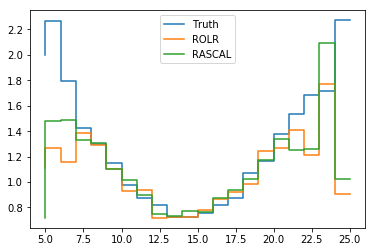

In [47]:
r_true = np.exp(np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5]))

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_rolr = rolr.predict([theta_0 * np.ones(n_nails), 
                       theta_1 * np.ones(n_nails),
                       x_test])[5:-5]
r_rascal = rascal.predict([theta_0 * np.ones(n_nails),
                           theta_1 * np.ones(n_nails),
                           x_test])[0][5:-5]

plt.step(range(5, n_nails-5), r_true, label="Truth")
plt.step(range(5, n_nails-5), r_rolr, label="ROLR")
plt.step(range(5, n_nails-5), r_rascal, label="RASCAL")

plt.legend()
plt.show()

## Model comparison

We now compare how well the different inference methods let us estimate the likelihood ratio `r(x|θ0,θ1) = p(x|θ0) / p(x|θ1)` as a function of the training sample size.

In [48]:
def compute_mse(p_train, p_estimated):
    p_ratio_train =  np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    
    return mse


def compute_mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
        
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    
    return mse

In [49]:
mses_nde = []
mses_scandal = []
mses_lrt = []
mses_rolr = []
mses_rascal = []

sample_sizes = [200, 500, 1000, 2000, 5000, 10000]
p_estimated = np.array([p_estimated_0, p_estimated_1])
x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)

for k, n in enumerate(sample_sizes):
    print('{0} samples'.format(n))
    
    # NDE - SCANDAL
    x, t_xz, theta = draw(n, random_state = 100 + k)
    
    nde = make_nde()
    nde.fit(
        theta,
        x,
        batch_size=batch_size, epochs=n_epochs, verbose=0
    )
    
    scandal = make_scandal()
    scandal.fit(
        [theta, x],
        [x, t_xz],
        batch_size=batch_size, epochs=n_epochs, verbose=0
    )
    
    nde_pred = nde.predict([theta_0, theta_1])
    scandal_pred = scandal.predict([np.array([[theta_0], [theta_1]]), np.zeros((2, n_nails))])[0]
    mse_nde = compute_mse(nde_pred, p_estimated)
    mse_scandal = compute_mse(scandal_pred, p_estimated)
    
    # LRT
    x, y = draw_lrt(n, random_state=200+k)
    
    lrt = make_lrt()
    lrt.fit(
        x, y,
        batch_size=batch_size, epochs=n_epochs, verbose=0
    )

    lrt_pred = log_r_from_s(
        lrt.predict(
            np.hstack([x_test, theta_0 * np.ones((n_nails, 1)), theta_1 * np.ones((n_nails, 1))])
        )[5:-5]
    )
    mse_lrt = compute_mse_ratio(lrt_pred.flatten(), p_estimated[:,5:-5], log=False)
    
    # ROLR - RASCAL
    x, thetas, log_r_xz, t_xz_0 = draw_ratio(n, random_state=300+k)
    
    rolr = make_rolr()
    rolr.fit(
        [thetas[:, 0], thetas[:, 1], x], 
        np.exp(log_r_xz), 
        batch_size=batch_size, epochs=n_epochs, verbose=0
    )
    
    rascal = make_rascal()
    rascal.fit(
        [thetas[:, 0], thetas[:, 1], x], 
        [np.exp(log_r_xz), t_xz_0], 
        batch_size=batch_size, epochs=n_epochs, verbose=0
    )
    
    rolr_pred = rolr.predict([theta_0 * np.ones(n_nails), 
                           theta_1 * np.ones(n_nails),
                           x_test])[5:-5]
    rascal_pred = rascal.predict([theta_0 * np.ones(n_nails),
                               theta_1 * np.ones(n_nails),
                               x_test])[0][5:-5]
    mse_rolr = compute_mse_ratio(rolr_pred.flatten(), p_estimated[:, 5:-5], log=True)
    mse_rascal = compute_mse_ratio(rascal_pred.flatten(), p_estimated[:, 5:-5], log=True)
    
    # Save results
    mses_nde.append(mse_nde)
    mses_rascal.append(mse_rascal)
    mses_lrt.append(mse_lrt)
    mses_rolr.append(mse_rolr)
    mses_scandal.append(mse_scandal)

200 samples


/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


500 samples
1000 samples
2000 samples
5000 samples
10000 samples


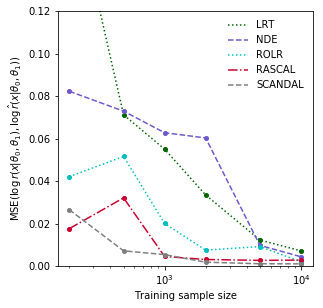

In [50]:
mses       = [mses_lrt, mses_nde, mses_rolr, mses_rascal, mses_scandal]
labels     = ['LRT', 'NDE', 'ROLR', 'RASCAL', 'SCANDAL']
colors     = ['darkgreen', 'slateblue',  'c', '#CC002E', '0.5']
linestyles = [':', '--', ':', '-.', '--']
linewidths = [1.5] * 5
markers    = ['o'] * 5

fig = plt.figure(figsize=(4.5, calculate_height(1, 4.5, extra_top_space=False)))
ax = plt.gca()

for s, (mse, label) in enumerate(zip(mses, labels)):
    plt.plot(sample_sizes, mse, 
             ms=4., marker=markers[s],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s])
    plt.plot([], [],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s],
             label=label)

plt.legend(frameon=False)
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.00, 0.12)
plt.xlabel(r"Training sample size")
plt.ylabel(r'MSE$(\log\,r(x|\theta_0, \theta_1),\log\,\hat{r}(x|\theta_0, \theta_1))$')

adjust_margins(1,4.5, extra_top_space=False)
plt.savefig('figures/model_comparison.pdf')